In [1]:
!pip install backtesting pandas numpy matplotlib python-binance

from backtesting import Backtest, Strategy
from typing import Union
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

/Users/leoinv/Documents/CODE/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/leoinv/Documents/CODE/.venv/lib/python3.12/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [3]:
from binance.client import Client
from binance.enums import HistoricalKlinesType
from typing import Union, Optional

def fetch_binance_data(
    symbol: str,
    interval: str = '1d',
    years: int = 10,
    start_time: Union[str, int] = '',
    end_time: Union[str, int] = '',
    kline_type: str = 'spot'
) -> pd.DataFrame:

    if years or (start_time == '' and end_time == ''):
        start_time = (datetime.now() - pd.Timedelta(days=365*years)).strftime('%Y-%m-%d %H:%M:%S')
        end_time = datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    if kline_type == 'spot':
        t = HistoricalKlinesType.SPOT
    else:
        t = HistoricalKlinesType.FUTURES

    klines = Client(None, None).get_historical_klines(
        symbol=symbol,
        interval=interval,
        start_str=start_time,
        end_str=end_time,
        klines_type=t
    )

    cols = [
        "open_time", "open", "high", "low", "close", "volume",
        "close_time", "quote_asset_volume", "num_trades",
        "taker_buy_base", "taker_buy_quote", "ignore"
    ]

    df = pd.DataFrame(klines, columns=cols)
    df[["open", "high", "low", "close", "volume"]] = df[["open", "high", "low", "close", "volume"]].astype(float)
    df["open_time"] = pd.to_datetime(df["open_time"], unit="ms", utc=True)
    df = df[["open_time", "open", "high", "low", "close", "volume"]]

    return df


In [4]:
# --- 1. Load Data ---
BTC_DOM_ = fetch_binance_data('BTCDOMUSDT', kline_type='futures', interval='1d', years=5)
BTC_ = fetch_binance_data('BTCUSDT', kline_type='spot', interval='1d', years=5)

# Align timestamps
BTC_DOM = BTC_DOM_.set_index('open_time')
BTC = BTC_.set_index('open_time')
BTC = BTC.reindex(BTC_DOM.index)

# --- 2. Compute Returns ---
BTC_rets = BTC['close'].pct_change().dropna()
BTC_DOM_rets = BTC_DOM['close'].pct_change().dropna()

# --- 3. Kelly Volatility Scaling ---
# Target volatility = 25% annualized long-term volatility
vol_est_ = BTC_rets.rolling(window=360).std() * np.sqrt(360) / 4
vol_est = BTC_rets.rolling(window=30).std() * np.sqrt(360)
kelly_weight = vol_est_ / vol_est
kelly_weight = kelly_weight.fillna(method='bfill')
kelly_weight = kelly_weight.clip(lower=0, upper=0.8)

# Resample to monthly frequency - Monthly rebalancing
weight_weekly = kelly_weight.resample('M').last().reindex(kelly_weight.index).ffill()

/var/folders/fm/h4956ym56j36k0_jj6p21c9w0000gn/T/ipykernel_45997/4271584066.py:19: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  kelly_weight = kelly_weight.fillna(method='bfill')
/var/folders/fm/h4956ym56j36k0_jj6p21c9w0000gn/T/ipykernel_45997/4271584066.py:23: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  weight_weekly = kelly_weight.resample('M').last().reindex(kelly_weight.index).ffill()


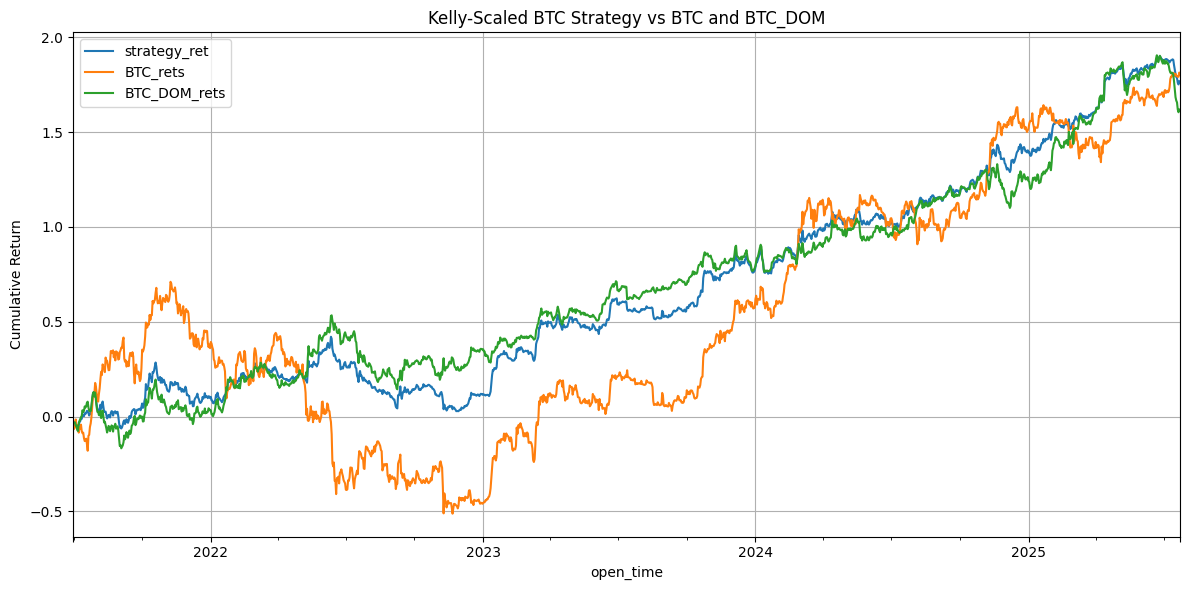

In [5]:
# --- 4. Align All Series ---
combined = pd.DataFrame({
    'BTC_rets': BTC_rets,
    'BTC_DOM_rets': BTC_DOM_rets ,  # Adjusted returns by beta
    'kelly_weight': weight_weekly
}).dropna()

combined['remain_weight'] = 1 - combined['kelly_weight']

# --- 5. Strategy Return ---
combined['strategy_ret'] = (
    combined['kelly_weight'] * combined['BTC_rets'] +
    combined['remain_weight'] * combined['BTC_DOM_rets']
)

# --- 6. Plot Cumulative Returns ---
combined[['strategy_ret', 'BTC_rets', 'BTC_DOM_rets']].cumsum().plot(
    title='Kelly-Scaled BTC Strategy vs BTC and BTC_DOM',
    figsize=(12, 6)
)
plt.ylabel('Cumulative Return')
plt.grid(True)
plt.tight_layout()
plt.show()

<Axes: xlabel='open_time'>

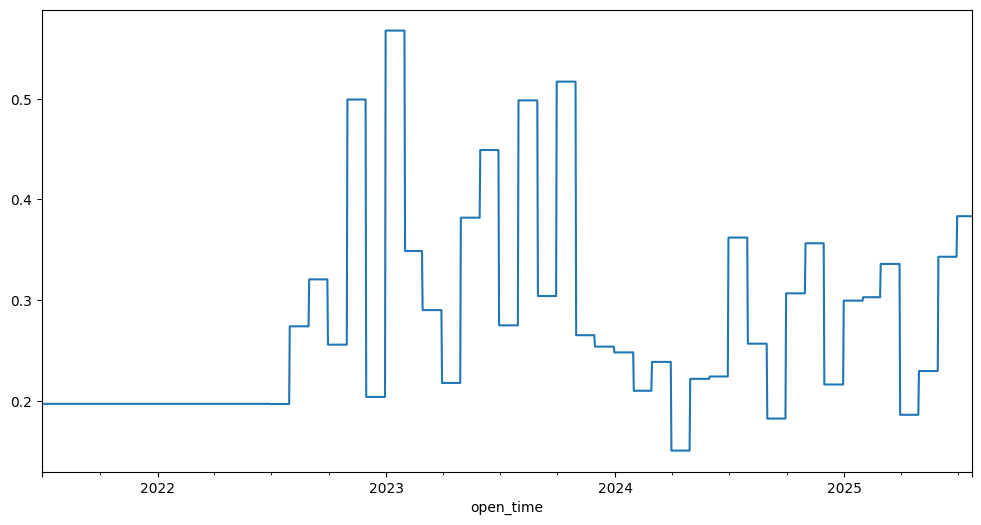

In [6]:
combined['kelly_weight'].plot(figsize=(12, 6))

In [7]:
# --- 7. Summary Stats Function ---
def summary_stats(returns, freq=365):
    ann_return = returns.mean() * freq
    ann_vol = returns.std() * np.sqrt(freq)
    sharpe = ann_return / ann_vol if ann_vol != 0 else np.nan
    return pd.Series({
        'Annual Return': round(ann_return, 2),
        'Annual Volatility': round(ann_vol, 2),
        'Sharpe Ratio': round(sharpe, 2)
    })

# --- 8. Print Stats ---
print("== Strategy Performance ==")
print(summary_stats(combined['strategy_ret']))
print("\n== BTC Buy-and-Hold Performance ==")
print(summary_stats(combined['BTC_rets']))
print("\n== BTC_DOM Buy-and-Hold Performance ==")
print(summary_stats(combined['BTC_DOM_rets']))

== Strategy Performance ==
Annual Return        0.43
Annual Volatility    0.28
Sharpe Ratio         1.54
dtype: float64

== BTC Buy-and-Hold Performance ==
Annual Return        0.44
Annual Volatility    0.55
Sharpe Ratio         0.81
dtype: float64

== BTC_DOM Buy-and-Hold Performance ==
Annual Return        0.40
Annual Volatility    0.34
Sharpe Ratio         1.19
dtype: float64
